In [1]:
import glob
import os

import xarray as xr
xr.set_options(keep_attrs=True)

import cartopy
from cartopy import crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

from tqdm.notebook import tqdm

import colormaps as cmo 

from cdo import *
cdo = Cdo()

from rich import print as rprint

%load_ext rich

import xcdat as xc
import xesmf as xe
import cf_xarray as cfxr
import numpy as np
import pandas as pd
import scipy as sc

ModuleNotFoundError: No module named 'cdo'

In [2]:
west = 106.3640
east = 107.1060
north = -5.1350
south = -6.1810

extent = [west, east, south, north]

rprint(extent)

[106.364, 107.106, -6.181, -5.135]

In [3]:
folder_chl = glob.glob('/mnt/d/Downloads/sentinel/data/chl/*.nc')
folder_chl.sort()

In [4]:
gridinfo = '/home/edskywalker/mygrid'
comp = dict(zlib=True, complevel=4)

for index, lis in tqdm(enumerate(folder_chl, start=0), total=len(folder_chl), desc='Processed'):
    try:
        datanya = xr.open_dataset(lis, engine='h5netcdf')
        datanya = datanya.cf.add_bounds(['lon','lat'])
        datanya = cdo.remapcon(gridinfo, input = datanya, returnXDataset = True)
        file_name = f'/mnt/d/Temp/chl_raw_{index:04d}.nc'
        datanya.to_netcdf(
            file_name,
            format = 'NETCDF4',
            unlimited_dims = 'time',
            encoding={var: comp for var in datanya.data_vars}
            )
    except:
        continue

Processed:   0%|          | 0/1815 [00:00<?, ?it/s]

In [5]:
lis_chl = glob.glob('/mnt/d/Temp/chl_*.nc')
chl_concat = cdo.mergetime(input=lis_chl, returnXDataset=True)
chl_concat = chl_concat.sortby('time')

In [6]:
rprint(chl_concat)

<xarray.Dataset>
Dimensions:  (time: 1808, lon: 513, lat: 532)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-03T02:56:48.405115 ... 2023-09-29T...
  * lon      (lon) float64 106.2 106.2 106.2 106.2 ... 107.3 107.3 107.3 107.3
  * lat      (lat) float64 -6.35 -6.347 -6.345 -6.342 ... -5.007 -5.005 -5.002
Data variables:
    chl_nn   (time, lat, lon) float32 ...
    chl_oc   (time, lat, lon) float32 ...
    tsm_nn   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 12:21:56 2024: cdo -O -s -f nc -mergetime /mnt/d...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [7]:
if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc')

chl_concat.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc', 
    format = 'NETCDF4',
    unlimited_dims = 'time',
    encoding={var: comp for var in chl_concat.data_vars}
    )

In [8]:
chl_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/chl_sentinel3_concatenated.nc')

rprint(chl_exported)

<xarray.Dataset>
Dimensions:  (time: 1808, lon: 513, lat: 532)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-03T02:56:48.405115 ... 2023-09-29T...
  * lon      (lon) float64 106.2 106.2 106.2 106.2 ... 107.3 107.3 107.3 107.3
  * lat      (lat) float64 -6.35 -6.347 -6.345 -6.342 ... -5.007 -5.005 -5.002
Data variables:
    chl_nn   (time, lat, lon) float32 ...
    chl_oc   (time, lat, lon) float32 ...
    tsm_nn   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 12:21:56 2024: cdo -O -s -f nc -mergetime /mnt/d...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

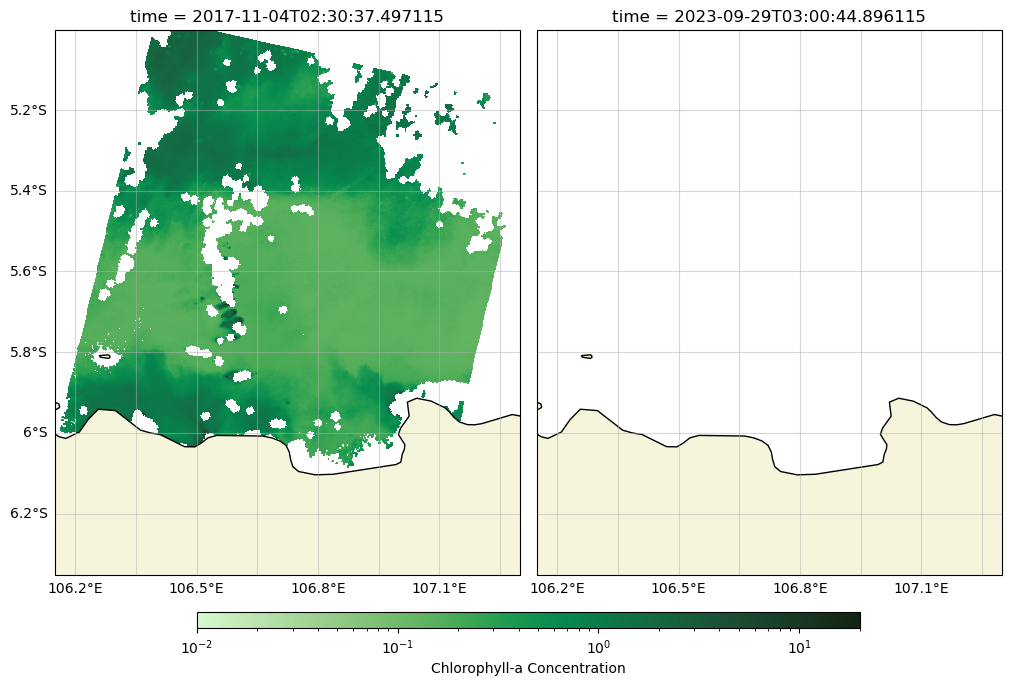

In [9]:
im = cm.ScalarMappable(norm=colors.LogNorm(0.01,20), cmap=cmo.algae)

fig, ax = plt.subplots(figsize=[10,8], ncols=2, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(2):
#    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i==0:
        ini.left_labels=False


chl_exported.chl_nn.isel(time=1).plot(ax=ax[0], add_colorbar=False, norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())
chl_exported.chl_nn.isel(time=-1).plot(ax=ax[1], add_colorbar=False, norm=colors.LogNorm(0.01,20), cmap=cmo.algae, zorder=0, transform=ccrs.PlateCarree())

cbar = plt.colorbar(im, shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Chlorophyll-a Concentration',ax=ax[0:])

In [10]:
cdo.cleanTempDir()
chl_exported.close()
for file in lis_chl:
    os.remove(file)

In [3]:
folder_ref = glob.glob('/mnt/d/Downloads/sentinel/data/ref/*.nc')
folder_ref.sort()

In [4]:
gridinfo = '/home/edskywalker/mygrid'
comp = dict(zlib=True, complevel=4)

for index, lis in tqdm(enumerate(folder_ref, start=0), total=len(folder_ref), desc='Processed'):
    try:
        datanya = xr.open_dataset(lis, engine='h5netcdf')
        datanya = datanya.cf.add_bounds(['lon','lat'])
        datanya = cdo.remapcon(gridinfo, input = datanya, returnXDataset = True)
        file_name = f'/mnt/d/Temp/ref_raw_{index:04d}.nc'
        datanya.to_netcdf(
            file_name,
            format = 'NETCDF4',
            unlimited_dims = 'time',
            encoding={var: comp for var in datanya.data_vars}
            )
    except:
        continue

Processed:   0%|          | 0/1811 [00:00<?, ?it/s]

In [5]:
lis_ref = glob.glob('/mnt/d/Temp/ref*.nc')
ref_concat = cdo.mergetime(input=lis_ref, returnXDataset=True)
ref_concat = ref_concat.sortby('time')

In [6]:
rprint(ref_concat)

<xarray.Dataset>
Dimensions:  (time: 1808, lon: 513, lat: 532)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-03T02:56:48.405115 ... 2023-09-29T...
  * lon      (lon) float64 106.2 106.2 106.2 106.2 ... 107.3 107.3 107.3 107.3
  * lat      (lat) float64 -6.35 -6.347 -6.345 -6.342 ... -5.007 -5.005 -5.002
Data variables:
    Oa06     (time, lat, lon) float32 ...
    Oa07     (time, lat, lon) float32 ...
    Oa08     (time, lat, lon) float32 ...
    Oa09     (time, lat, lon) float32 ...
    Oa10     (time, lat, lon) float32 ...
    Oa11     (time, lat, lon) float32 ...
    Oa12     (time, lat, lon) float32 ...
    rdi      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 22 00:53:13 2024: cdo -O -s -f nc -mergetime /mnt/d...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [7]:
if os.path.exists('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc'):
    os.remove('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc')

ref_concat.to_netcdf(
    '/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc', 
    format = 'NETCDF4',
    unlimited_dims = 'time',
    encoding={var: comp for var in ref_concat.data_vars}
    )

In [8]:
ref_exported = xr.open_dataset('/mnt/d/Documents/Programming/Python/Output/IMBER/Data/ref_sentinel3_concatenated.nc')

rprint(ref_exported)

<xarray.Dataset>
Dimensions:  (time: 1808, lon: 513, lat: 532)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-03T02:56:48.405115 ... 2023-09-29T...
  * lon      (lon) float64 106.2 106.2 106.2 106.2 ... 107.3 107.3 107.3 107.3
  * lat      (lat) float64 -6.35 -6.347 -6.345 -6.342 ... -5.007 -5.005 -5.002
Data variables:
    Oa06     (time, lat, lon) float32 ...
    Oa07     (time, lat, lon) float32 ...
    Oa08     (time, lat, lon) float32 ...
    Oa09     (time, lat, lon) float32 ...
    Oa10     (time, lat, lon) float32 ...
    Oa11     (time, lat, lon) float32 ...
    Oa12     (time, lat, lon) float32 ...
    rdi      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 22 00:53:13 2024: cdo -O -s -f nc -mergetime /mnt/d...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

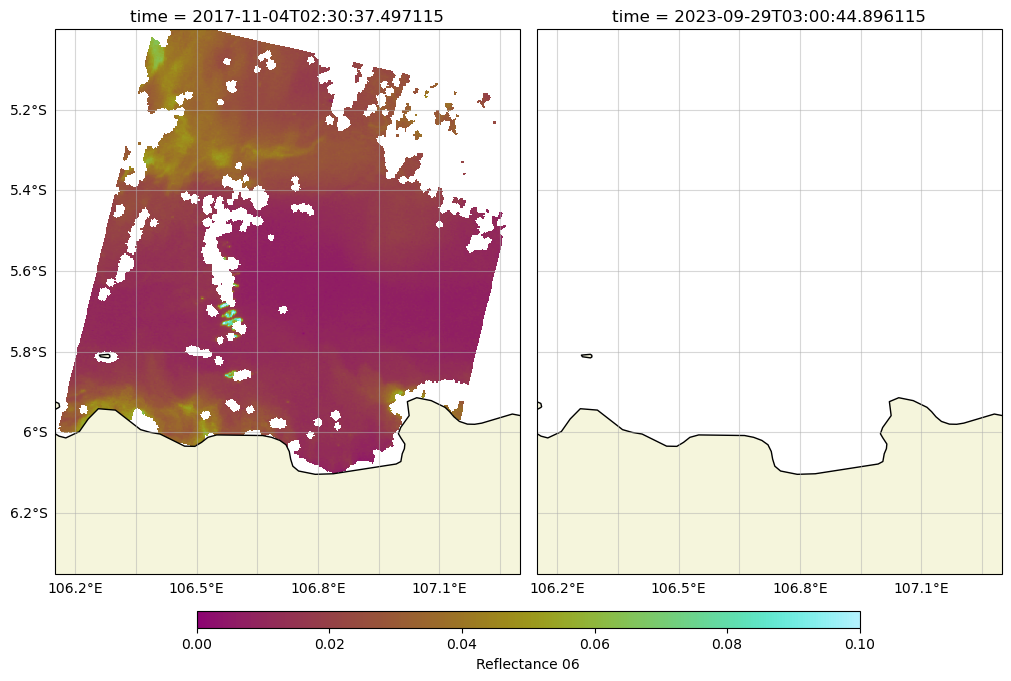

In [9]:
im = cm.ScalarMappable(norm=colors.Normalize(0,0.1), cmap=cmo.hawaii)

fig, ax = plt.subplots(figsize=[10,8], ncols=2, layout='constrained', subplot_kw=dict(projection=ccrs.Mercator()))

for i in range(2):
#    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = 'beige', edgecolor='black', zorder = 1)

    ini = ax[i].gridlines(draw_labels = True, alpha=0.5)
    ini.top_labels = False
    ini.right_labels = False
    if not i==0:
        ini.left_labels=False

ref_exported.Oa06.isel(time=1).plot.pcolormesh(ax=ax[0], add_colorbar=False, norm=colors.Normalize(0,0.1), cmap=cmo.hawaii, zorder=0, transform=ccrs.PlateCarree())
ref_exported.Oa06.isel(time=-1).plot.pcolormesh(ax=ax[1], add_colorbar=False, norm=colors.Normalize(0,0.1), cmap=cmo.hawaii, zorder=0, transform=ccrs.PlateCarree())

cbar = plt.colorbar(im, shrink=0.7, aspect=40, pad=0.02, orientation = 'horizontal', label = 'Reflectance 06',ax=ax[0:])

In [10]:
cdo.cleanTempDir()
ref_exported.close()
for file in lis_ref:
    os.remove(file)